In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = '/content/drive/MyDrive/IAI PROJECT/'

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Activation, ReLU
from tensorflow.keras.layers import BatchNormalization, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model, Sequential

In [4]:
def convolution_operation(entered_input, filters=16):
    # Taking first input and implementing the first conv block
    conv1 = Conv2D(filters, kernel_size = (3,3), padding = "same")(entered_input)
    batch_norm1 = BatchNormalization()(conv1)
    act1 = ReLU()(batch_norm1)

    # Taking first input and implementing the second conv block
    conv2 = Conv2D(filters, kernel_size = (3,3), padding = "same")(act1)
    batch_norm2 = BatchNormalization()(conv2)
    act2 = ReLU()(batch_norm2)

    return act2

In [5]:
def encoder(entered_input, filters=16):
    # Collect the start and end of each sub-block for normal pass and skip connections
    enc1 = convolution_operation(entered_input, filters)
    MaxPool1 = MaxPooling2D(strides = (2,2))(enc1)
    return enc1, MaxPool1

In [6]:
def decoder(entered_input, skip, filters=64):
    # Upsampling and concatenating the essential features
    Upsample = Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(entered_input)
    Connect_Skip = Concatenate()([Upsample, skip])
    out = convolution_operation(Connect_Skip, filters)
    return out

In [7]:
def U_Net(Image_Size):
    # Take the image size and shape
    input1 = Input(Image_Size)

    # Construct the encoder blocks
    skip1, encoder_1 = encoder(input1, 64)
    skip2, encoder_2 = encoder(encoder_1, 64*2)

    # Preparing the next block
    conv_block = convolution_operation(encoder_2, 64*16)

    # Construct the decoder blocks
    decoder_1 = decoder(conv_block, skip2, 64*2)
    decoder_2 = decoder(decoder_1, skip1, 64)

    out = Conv2D(20, 1, padding="same", activation="sigmoid")(decoder_2)

    model = Model(input1, out)
    return model

In [8]:
input_shape = (1200, 1920,3)
model = U_Net(input_shape)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1200, 1920, 3)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 1200, 1920, 64)       1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 1200, 1920, 64)       256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 1200, 1920, 64)       0         ['batch_normalization[0][0

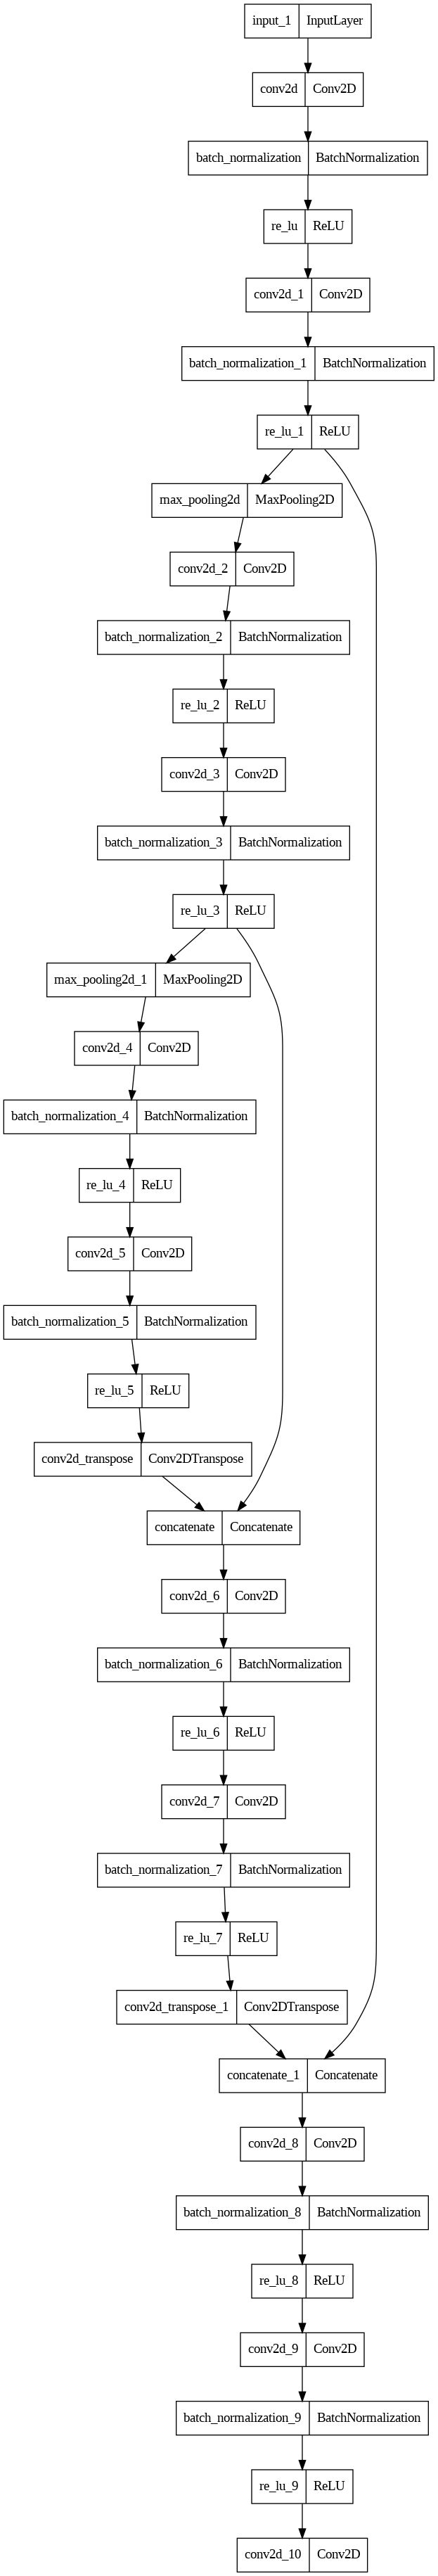

In [9]:
tf.keras.utils.plot_model(model, "model.png", show_shapes=False, show_dtype=False, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

In [10]:
import os

input_dir = "/content/drive/MyDrive/IAI PROJECT/train/input"
target_dir = "/content/drive/MyDrive/IAI PROJECT/train/labels"

input_dir_test = "/content/drive/MyDrive/IAI PROJECT/test/input"
target_dir_test = "/content/drive/MyDrive/IAI PROJECT/test/labels"

img_size = (1200, 1920)
num_classes = 20
batch_size = 64

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)


input_img_paths_test = sorted(
    [
        os.path.join(input_dir_test, fname)
        for fname in os.listdir(input_dir_test)
        if fname.endswith(".jpg")
    ]
)
target_img_paths_test = sorted(
    [
        os.path.join(target_dir_test, fname)
        for fname in os.listdir(target_dir_test)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 3302
/content/drive/MyDrive/IAI PROJECT/train/input/frame000000-1581624075_250.jpg | /content/drive/MyDrive/IAI PROJECT/train/labels/frame000000-1581624075_250.png
/content/drive/MyDrive/IAI PROJECT/train/input/frame000000-1581791678_408.jpg | /content/drive/MyDrive/IAI PROJECT/train/labels/frame000000-1581791678_408.png
/content/drive/MyDrive/IAI PROJECT/train/input/frame000000-1581797150_409.jpg | /content/drive/MyDrive/IAI PROJECT/train/labels/frame000000-1581797150_409.png
/content/drive/MyDrive/IAI PROJECT/train/input/frame000002-1581624075_450.jpg | /content/drive/MyDrive/IAI PROJECT/train/labels/frame000002-1581624075_450.png
/content/drive/MyDrive/IAI PROJECT/train/input/frame000002-1581791678_608.jpg | /content/drive/MyDrive/IAI PROJECT/train/labels/frame000002-1581791678_608.png
/content/drive/MyDrive/IAI PROJECT/train/input/frame000002-1581797150_609.jpg | /content/drive/MyDrive/IAI PROJECT/train/labels/frame000002-1581797150_609.png
/content/drive/MyDrive

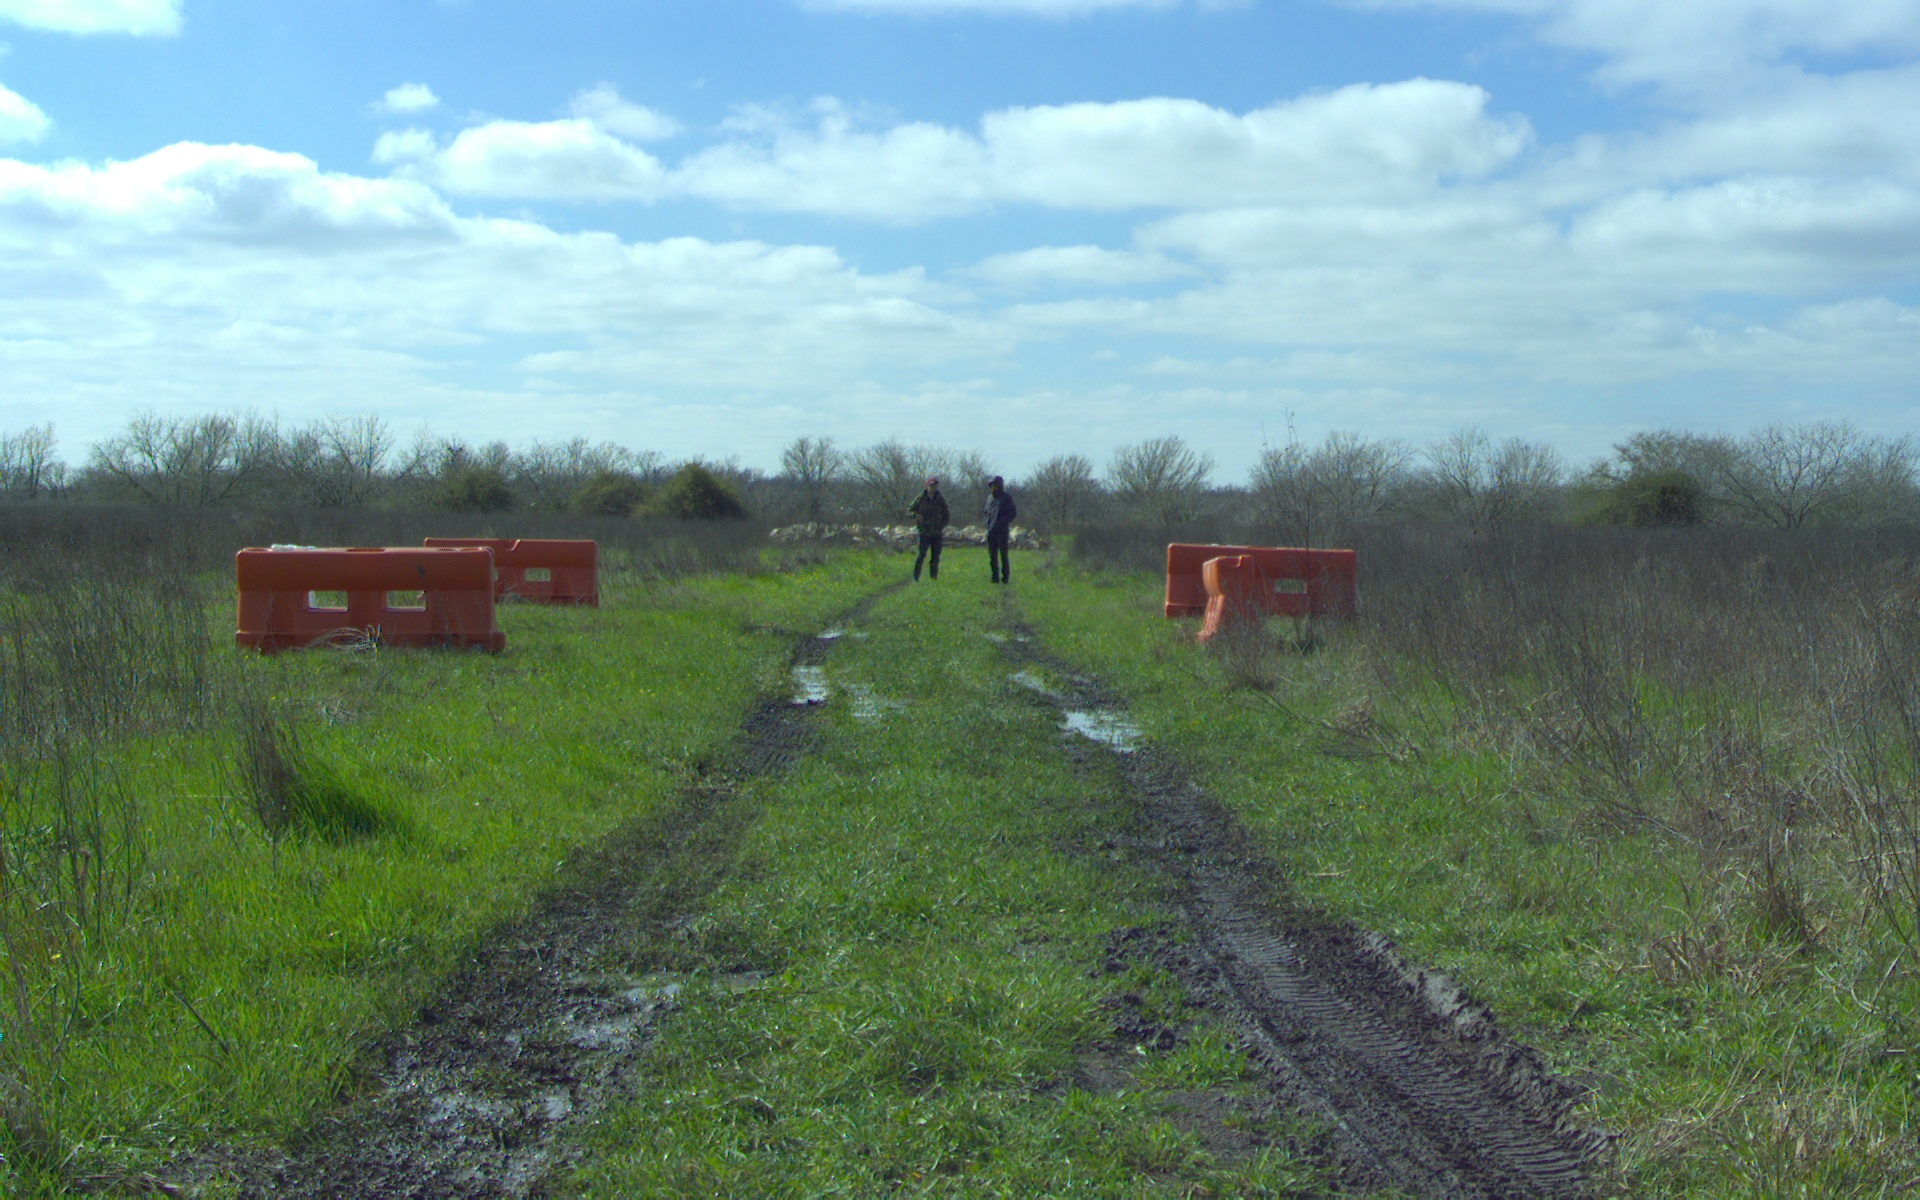

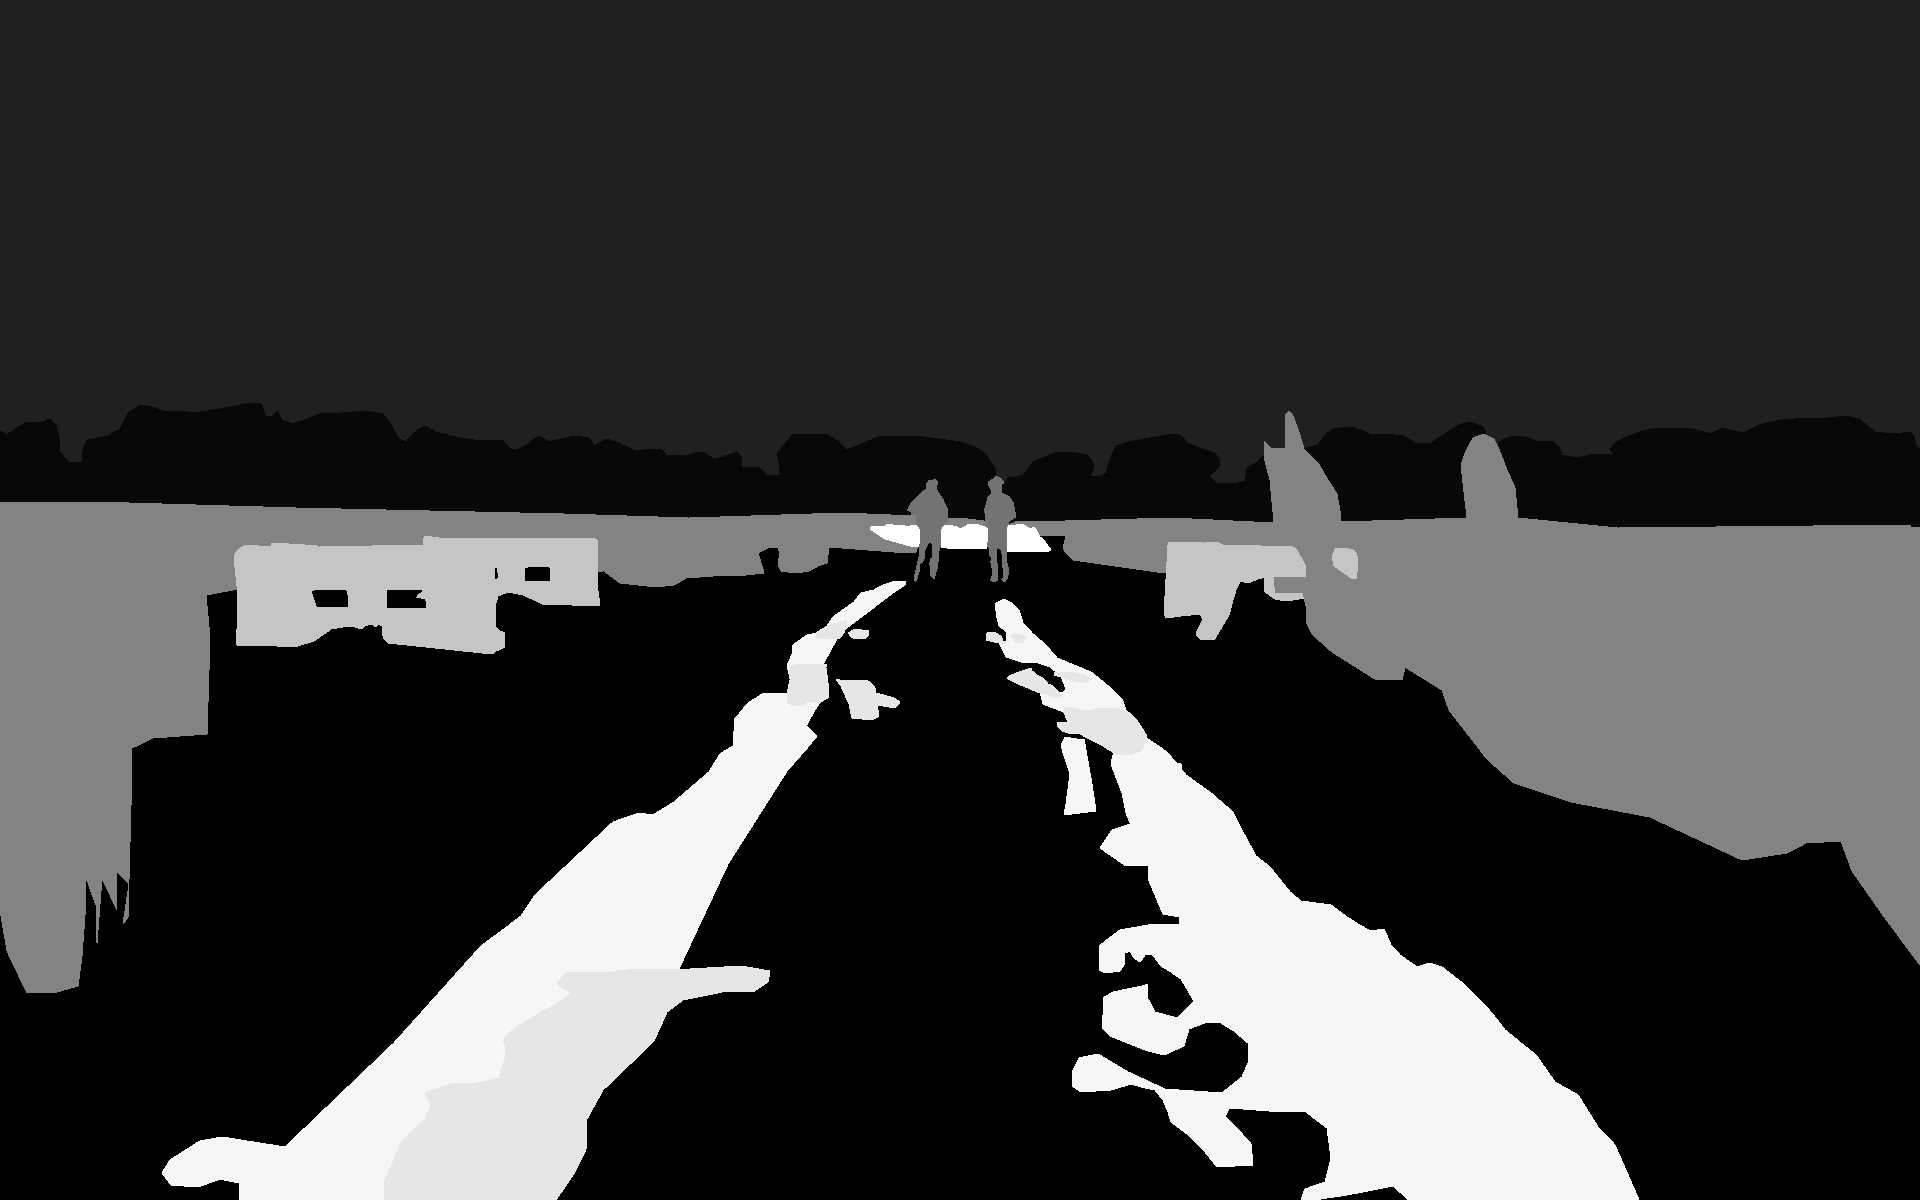

In [11]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

# Display input image #7
display(Image(filename=input_img_paths[9]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[9]))
display(img)

In [12]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


class UnstructuredTerrain(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            y[j] -= 1
        return x, y

In [13]:
# Instantiate data Sequences for each split
train_gen = UnstructuredTerrain(
    batch_size, img_size, input_img_paths,target_img_paths
)

test_gen = UnstructuredTerrain(batch_size, img_size, input_img_paths_test, target_img_paths_test)


In [ ]:

model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 15
model.train(
    train_gen,
    test_gen,
    checkpoints_path = "/tmp/vgg_unet_1" , epochs=20 )

Verifying training dataset


100%|██████████| 3302/3302 [03:34<00:00, 15.39it/s]


Dataset verified! 
Epoch 1/20
512/512 [==============================] - ETA: 0s - loss: 0.5353 - accuracy: 0.8366
Epoch 1: saving model to /tmp/vgg_unet_1.00001
512/512 [==============================] - 148s 257ms/step - loss: 0.5353 - accuracy: 0.8366
Epoch 2/20
512/512 [==============================] - ETA: 0s - loss: 0.3467 - accuracy: 0.8781
Epoch 2: saving model to /tmp/vgg_unet_1.00002
512/512 [==============================] - 129s 253ms/step - loss: 0.3467 - accuracy: 0.8781
Epoch 3/20
512/512 [==============================] - ETA: 0s - loss: 0.3056 - accuracy: 0.8904
Epoch 3: saving model to /tmp/vgg_unet_1.00003
512/512 [==============================] - 132s 257ms/step - loss: 0.3056 - accuracy: 0.8904
Epoch 4/20
512/512 [==============================] - ETA: 0s - loss: 0.2780 - accuracy: 0.8986
Epoch 4: saving model to /tmp/vgg_unet_1.00004
512/512 [==============================] - 131s 255ms/step - loss: 0.2780 - accuracy: 0.8986
Epoch 5/20
512/512 [=================